In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import TypeAlias
%matplotlib inline

Number: TypeAlias = int | float

def number(cin: str) -> Number | None:
    result: Number
    if '.' in cin:
        try:
            result = float(cin)
        except ValueError:
            return None

        return result

    try:
        result = int(cin)
    except ValueError:
        return None
    
    return result

def valid(msg: str, value_min: Number | None = None, value_max: Number | None = None) -> Number | None:
    result: Number | None = None

    if value_min == None and value_max == None:
        while result is None or result < 0:
            result = number(input(msg))

            if result < 0:
                print('El valor tiene que ser mayor que 0')
            if result is None:
                print('El valor tiene que ser númerico')
        
        return result

    if value_min == None and value_max != None:
        if value_max < 0:
            return result

        if value_max == 0:
            return 0

        while result is None or result < 0 or result >= value_max:
            result = number(input(msg))

            if result is None:
                print('El valor tiene que ser númerico')
                continue

            if result < 0:
                print('El valor tiene que ser mayor que 0')
            if result >= value_max:
                print(f'El valor tiene que ser menor que {value_max}')
        
        return result

    if value_max == None and value_min != None:
        if value_min < 0:
            value_min = 0

        while result is None or result < 0 or result <= value_min:
            result = number(input(msg))

            if result is None:
                print('El valor tiene que ser númerico')
                continue

            if result < 0:
                print('El valor tiene que ser mayor que 0')
            if result <= value_min:
                print(f'El valor tiene que ser mayor que {value_min}')

        return result
    
    if value_min > value_max:
        return result
    
    if value_min == value_max:
        return value_min

    while result is None or result < 0 or result <= value_min or result >= value_max:
        result = number(input(msg))

        if result is None:
            print('El valor tiene que ser númerico')
            continue

        if result < 0:
            print('El valor tiene que ser mayor que 0')
        else:
            if result <= value_min:
                print(f'El valor tiene que ser mayor que {value_min}')
            if result >= value_max:
                print(f'El valor tiene que ser menor que {value_max}')

    return result


In [17]:
# No incluye al 0
k: Number = valid('Elasticity constant [N/m]: ', value_min=0)
b: Number = valid('Damping constant [Kg/s]: ', value_min=0)
m: Number = valid('Body mass [Kg]: ', value_min=0)

# Incluye al 0
x0: Number = valid('Initial position [m]: ')
v0: Number = valid('Initial velocity [m/s]: ')

ti: Number = valid('Initial time [s]: ')
tf: Number = valid('Final time [s]: ', value_min=ti)
delta: Number = tf - ti

print('\nUser input:')
print(f'Elasticity constant: {k = } N/m')
print(f'Damping constant: {b = } Kg/s')
print(f'Body mass: {m = } Kg')
print(f'Initial position: {x0 = } m')
print(f'Initial velocity: {v0 = } m/s')
print(f'Initial time: {ti = } s')
print(f'Final time: {tf = } s')


User input:
Elasticity constant: k = 500 N/m
Damping constant: b = 100 Kg/s
Body mass: m = 200 Kg
Initial position: x0 = 0 m
Initial velocity: v0 = 20 m/s
Initial time: ti = 0 s
Final time: tf = 15 s


In [18]:
# 1ra parte salida programa
w0: Number = np.sqrt(k / m)
factor_a: Number = b / (2*m)
mechanical_energy: Number = (k * x0**2)/2 + (m * v0**2)/2

print(f'Natural angular frequency: {w0} rad/s')
print(f'Damping parameter: {factor_a} s^-1')
print(f'Total mechanical energy given: {mechanical_energy} J')

over, critical, under = b > 2*np.sqrt(k*m), b == 2*np.sqrt(k*m), b < 2*np.sqrt(k*m)

if over or critical:
    lambda1: float = -factor_a + np.sqrt(factor_a**2 - w0**2)
    lambda2: float = -factor_a - np.sqrt(factor_a**2 - w0**2)
    
    print('\nThe equation roots are:')
    print(f'Root 1: {lambda1}')
    print(f'Root 2: {lambda2}')


Natural angular frequency: 1.5811388300841898 rad/s
Damping parameter: 0.25 s^-1
Total mechanical energy given: 40000.0 J


In [19]:
# 2da parte salida programa

print('The system is\n=> ', end='')
if over:
    print('Overdamped')

    c2: float = (v0 - x0*lambda1) / (lambda2-lambda1)
    c1: float = x0 - c2
elif critical:
    print('Critically damped')

    c2: float = v0 + factor_a*x0
    c1: float = x0
else:
    print('Underdamped')

    c2: float = -np.pi/2 if x0 == 0 else np.arctan(-(v0/(x0*w0) + b/(2*m)))
    c1: float = np.sqrt((x0**2 + (v0/w0)**2) / ((b/(2*m*w0)*np.cos(c2))**2 + b/(2*m*w0)*np.sin(2*c2) + 1))

print('\nConstants value')
print(f'{c1 = }')
print(f'{c2 = }')

The system is
=> Underdamped

Constants value
c1 = 12.649110640673516
c2 = -1.5707963267948966


In [20]:
# 3ra parte salida del programa

df_data: pd.DataFrame = pd.DataFrame(
    {'time': np.linspace(ti, tf, 1_000)}
)

if under:
    angular_freq: float = np.sqrt(k/m - (factor_a)**2)
    df_data['position'] = c1 * np.exp(-factor_a*df_data['time']) * np.cos(angular_freq * df_data['time'] + c2)
    df_data['velocity'] = -c1*factor_a*np.exp(-factor_a*df_data['time'])*np.cos(angular_freq*df_data['time'] + c2) - c1*angular_freq*np.exp(-factor_a*df_data['time'])*np.sin(angular_freq*df_data['time'] + c2)
    df_data['acceleration'] = 2*c2*factor_a*np.exp(-factor_a*df_data['time']) * np.sin(angular_freq*df_data['time'] + c2) + (factor_a**2 - angular_freq**2)*np.exp(-factor_a*df_data['time'])*np.cos(angular_freq*df_data['time'] + c2)
elif critical:
    df_data['position'] = (c1 + c2*df_data['time']) * np.e**(-factor_a * df_data['time'])
    df_data['velocity'] = -factor_a*c1*np.e**(-factor_a*df_data['time']) + c2*np.e**(-factor_a*df_data['time']) - c2*factor_a*df_data['time']*np.e**(-factor_a*df_data['time'])
    df_data['acceleration'] = factor_a*np.exp(-factor_a*df_data['time']) * (c1*factor_a - 2*c2 + c2*factor_a*df_data['time'])
else:
    df_data['position'] = c1*np.e**(lambda1*df_data['time']) + c2*np.e**(lambda2*df_data['time'])
    df_data['velocity'] = lambda1*c1*np.e**(lambda1*df_data['time']) + lambda2*c1*np.e**(lambda2*df_data['time'])
    df_data['acceleration'] = lambda1**2 * c1*np.exp(lambda1*df_data['time']) + lambda2**2 * c2*np.exp(lambda2*df_data['time'])

df_data['kinetic'] = m*df_data['velocity']**2 / 2
df_data['potential'] = k*df_data['position']**2 / 2

df_data

,time,position,velocity,acceleration,kinetic,potential
0,0.000000,7.745346e-16,19.748418,0.785398,39000.000000,1.499760e-28
1,0.015015,2.953847e-01,19.595174,0.726779,38397.084722,2.181304e+01
2,0.030030,5.883943e-01,19.432074,0.668190,37760.550691,8.655197e+01
3,0.045045,8.788820e-01,19.259283,0.609664,37091.999147,1.931084e+02
4,0.060060,1.166704e+00,19.076971,0.551234,36393.081522,3.402993e+02
...,...,...,...,...,...,...
995,14.939940,-2.935397e-01,-0.037296,0.050713,0.139098,2.154138e+01
996,14.954955,-2.940150e-01,-0.026030,0.051246,0.067756,2.161120e+01
997,14.969970,-2.943217e-01,-0.014834,0.051746,0.022004,2.165631e+01
998,14.984985,-2.944608e-01,-0.003713,0.052213,0.001379,2.167679e+01


<Axes: title={'center': '$x(t)$'}, xlabel='Time ($s$)', ylabel='Position ($m$)'>

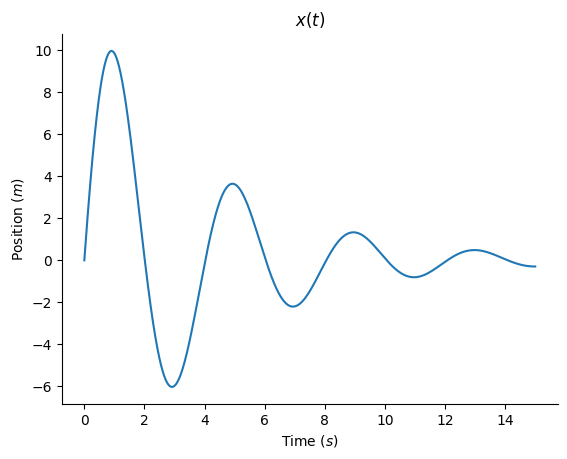

In [21]:
# Gráfica x(t)

plt.title('$x(t)$')
plt.xlabel('Time ($s$)')
plt.ylabel('Position ($m$)')

sns.despine()
sns.lineplot(
    data = df_data, x='time', y='position'
)

<Axes: title={'center': '$v_x(t)$'}, xlabel='Time ($s$)', ylabel='Velocity ($m/s$)'>

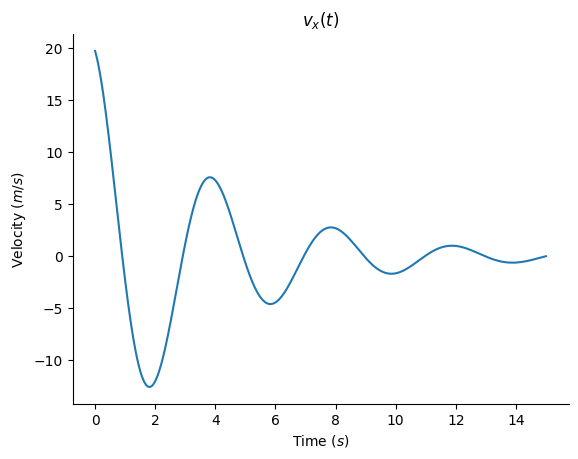

In [22]:
# Gráfica v(t)

plt.title('$v_x(t)$')
plt.xlabel('Time ($s$)')
plt.ylabel('Velocity ($m/s$)')

sns.despine()
sns.lineplot(
    data = df_data, x='time', y='velocity'
)

<Axes: title={'center': '$a(t)$'}, xlabel='Time ($s$)', ylabel='Acceleration ($m/s^2$)'>

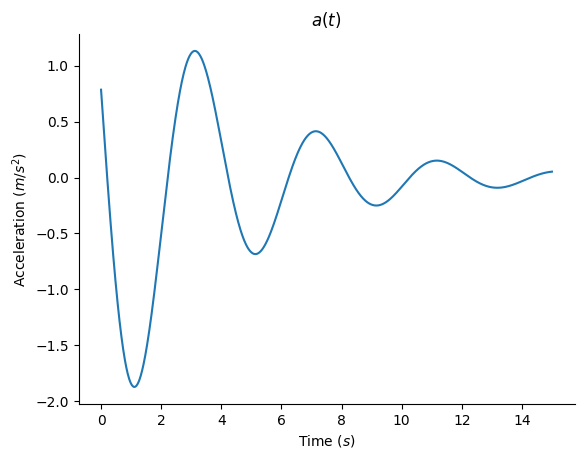

In [23]:
# Gráfica a(t)

plt.title('$a(t)$')
plt.xlabel('Time ($s$)')
plt.ylabel('Acceleration ($m/s^2$)')

sns.despine()
sns.lineplot(
    data = df_data, x='time', y='acceleration'
)

<Axes: title={'center': '$E_c (t)$'}, xlabel='Time ($s$)', ylabel='Energy ($J$)'>

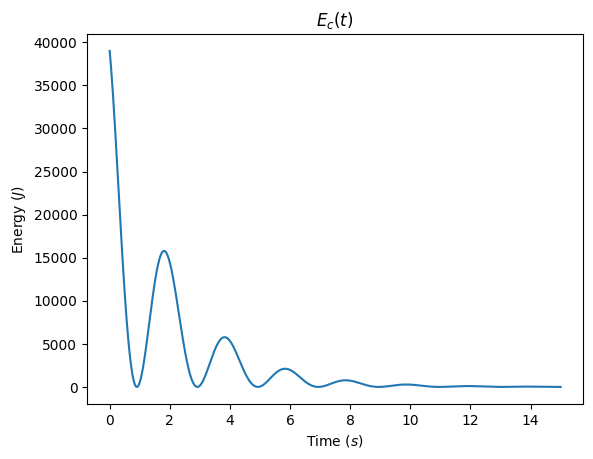

In [24]:
# E_c(t)

plt.title('$E_c (t)$')
plt.xlabel('Time ($s$)')
plt.ylabel('Energy ($J$)')

sns.lineplot(
    data = df_data, x='time', y='kinetic'
)

<Axes: title={'center': 'Potential energy($t$)'}, xlabel='Time ($s$)', ylabel='Energy ($J$)'>

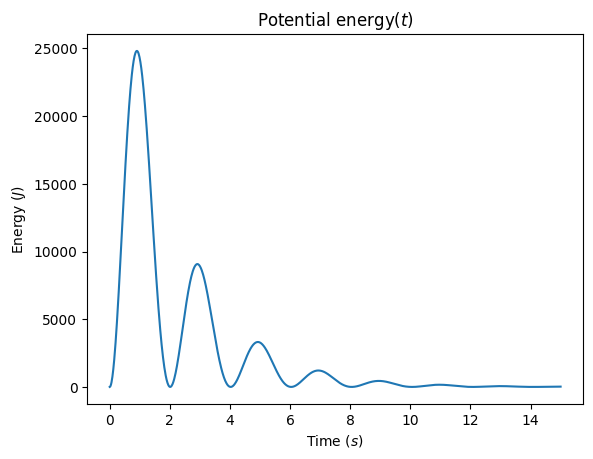

In [25]:
# U(t)

plt.title('Potential energy($t$)')
plt.xlabel('Time ($s$)')
plt.ylabel('Energy ($J$)')

sns.lineplot(
    data = df_data, x='time', y='potential'
)